In [1]:
import datetime

import numpy as np
import pandas as pd
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib.finance import quotes_historical_yahoo_ochl

from hmmlearn import hmm 
from sklearn.preprocessing import scale
import tushare as ts

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
#--- Finance data
stock_basic = ts.get_stock_basics()
code_list = stock_basic.index.values

In [3]:
df = ts.get_k_data('002743')

Dates = df.date.values # 日期列
close_v = df.close.values # 收盘价
volume = df.volume.values # 交易数
high = df.high.values # 最高价格
low = df.low.values # 最低价格

In [4]:
diff = np.diff(close_v)[4:]
volume_5 = np.log(volume[5:]) - np.log(volume[:-5])
close_5 = np.log(close_v[5:]) - np.log(close_v[:-5])
logDel = np.log(high[5:]) - np.log(low[5:])
dates = pd.to_datetime(Dates[5:])
close = close_v[5:]

* spherical：是指在每个马尔可夫隐含状态下，可观察态向量的所有特性分量使用相同的方差值。对应协方差矩阵的非对角为0，对角值相等，即球面特性。这是最简单的高斯分布PDF。
* diag：是指在每个马尔可夫隐含状态下，可观察态向量使用对角协方差矩阵。对应协方差矩阵非对角为0，对角值不相等。diag是hmmlearn里面的默认类型。
* full：是指在每个马尔可夫隐含状态下，可观察态向量使用完全协方差矩阵。对应的协方差矩阵里面的元素都是不为零。
* tied：是指所有的马尔可夫隐含状态使用相同的完全协方差矩阵。

In [5]:
# scale归一化处理：均值为0和方差为1
# 将价格和交易数组成输入数据
X = np.column_stack([volume_5, close_5, logDel])

# 训练高斯HMM模型，这里假设隐藏状态4个
model = hmm.GaussianHMM(6, covariance_type = "full", n_iter = 300)
model.fit(X)

# 预测隐状态
hidden_states = model.predict(X)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWa

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


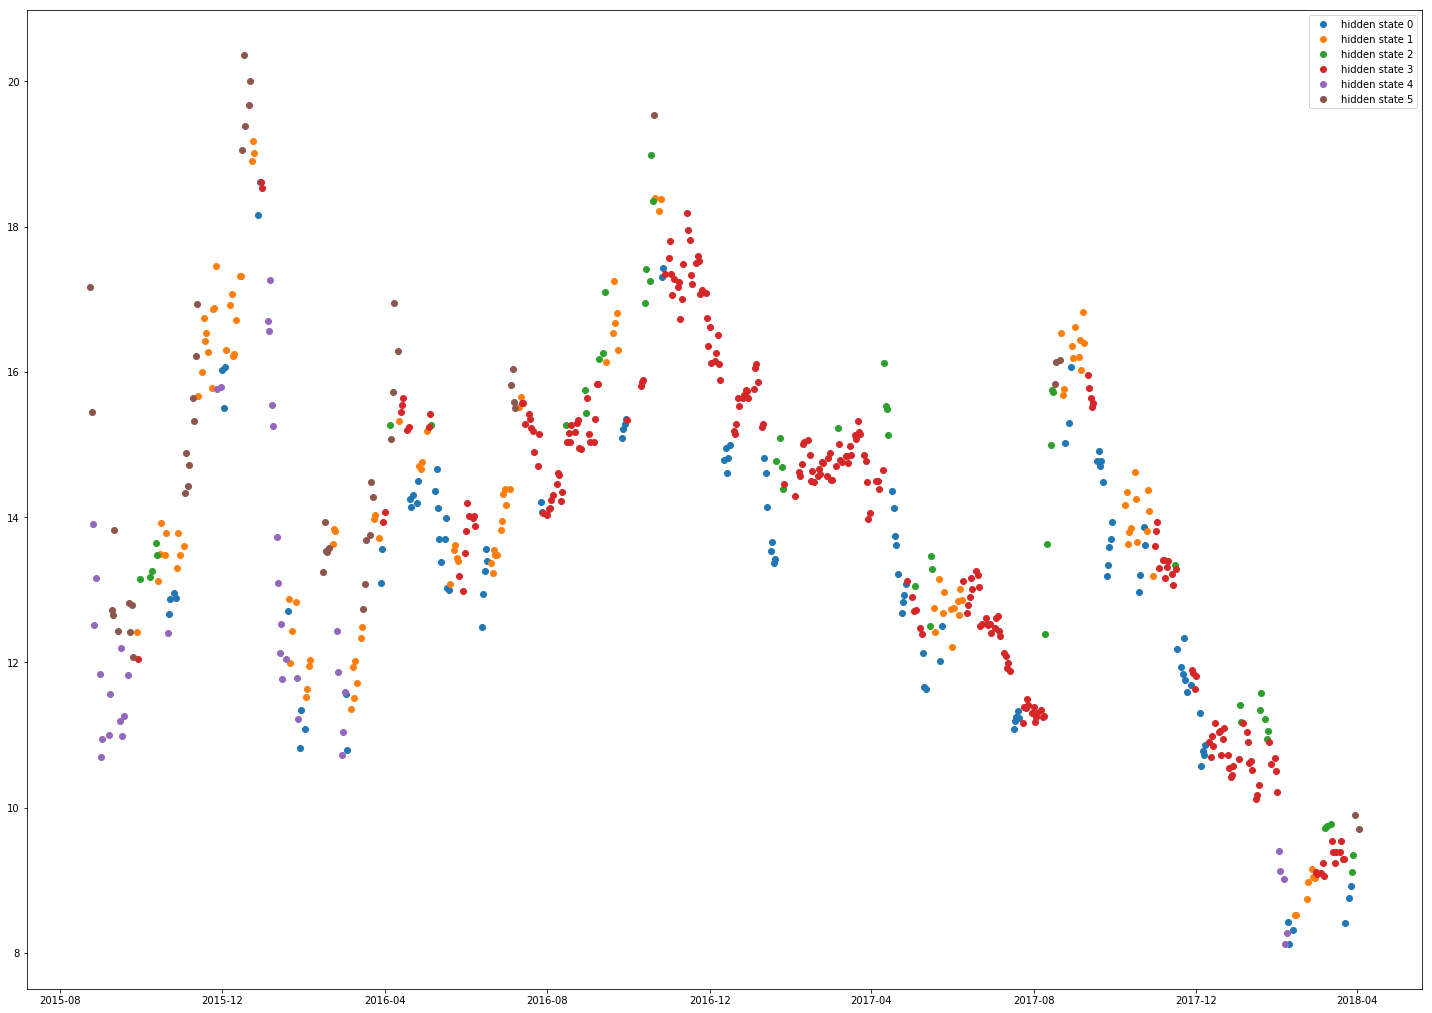

In [6]:
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states == i)
    plt.plot_date(dates[pos], close[pos], 'o', label='hidden state %d'%i, lw=2)
    plt.legend(loc="left")


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:638: UserWarning: Unrecognized location "left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


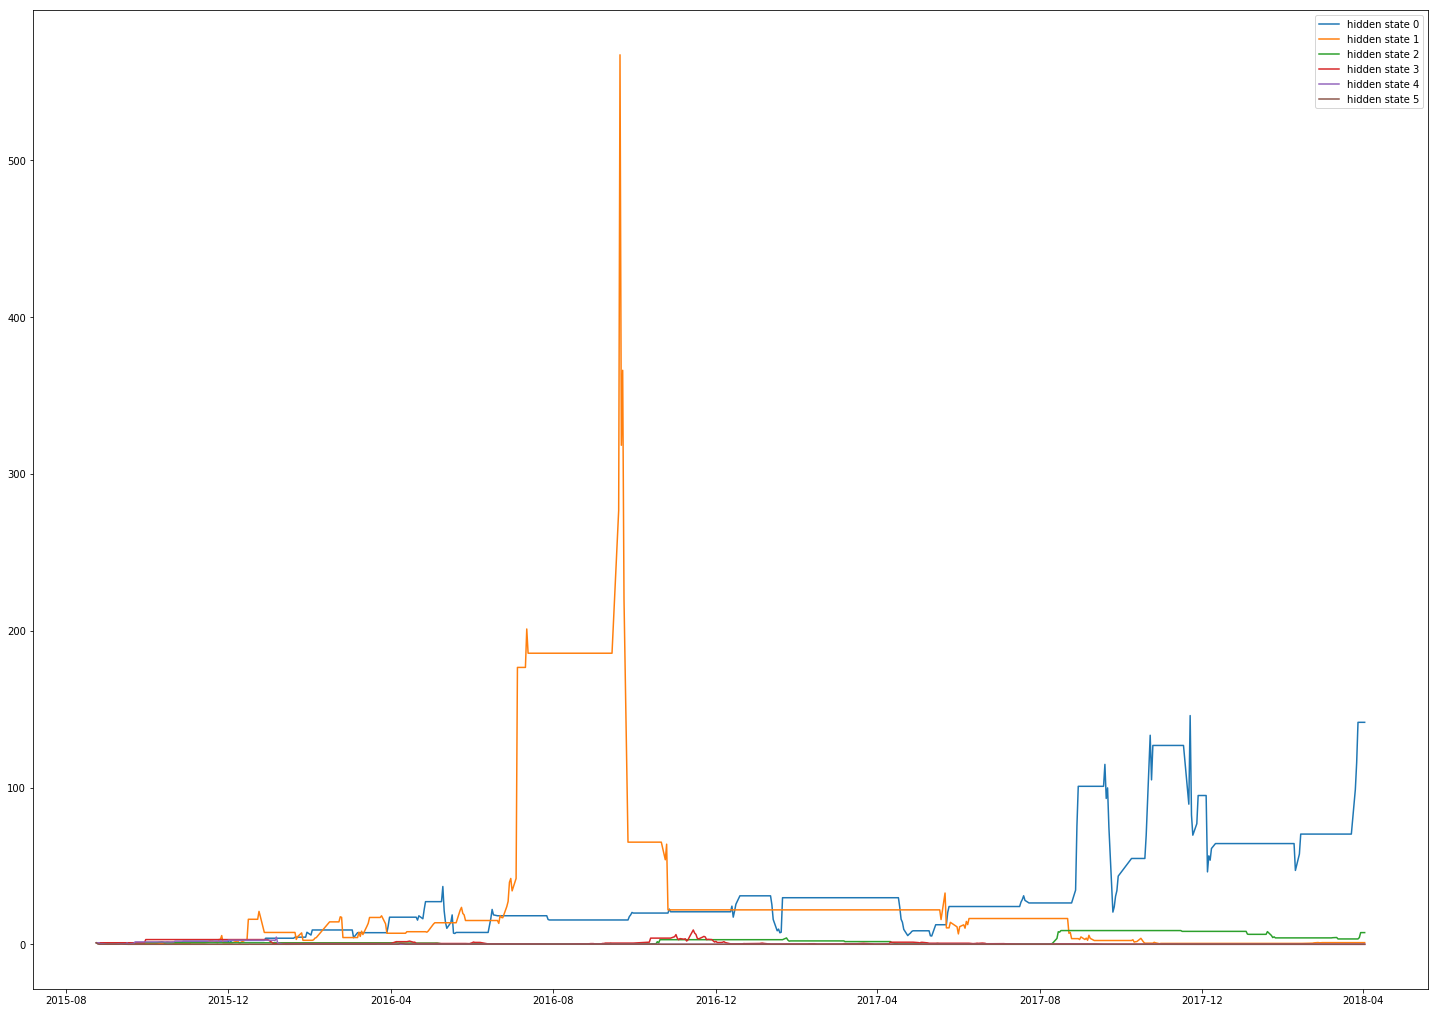

In [8]:
res = pd.DataFrame({'Date':dates,'logRet_1':diff,'state':hidden_states}).set_index('Date')
plt.figure(figsize=(25, 18)) 
for i in range(model.n_components):
    pos = (hidden_states==i)
    pos = np.append(0,pos[:-1])#第二天进行买入操作
    df = res.logRet_1
    res['state_ret%s'%i] = df.multiply(pos)
    plt.plot_date(dates,np.exp(res['state_ret%s'%i].cumsum()),'-',label='hidden state %d'%i)
    plt.legend(loc="left")